In [1]:
# %config InlineBackend.figure_format = "retina"

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# from pandas.core.common import SettingWithCopyWarning
%matplotlib inline
warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# 3장 - 금융 시계열 시각화

## 3.1 시계열 데이터의 기본 시각화

In [67]:
import pandas as pd 
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

### 다운로드 및 단순수익률 계산
> 2020년의 마이크로소프트 주가를 다운로드하고 단순 수익률 계산

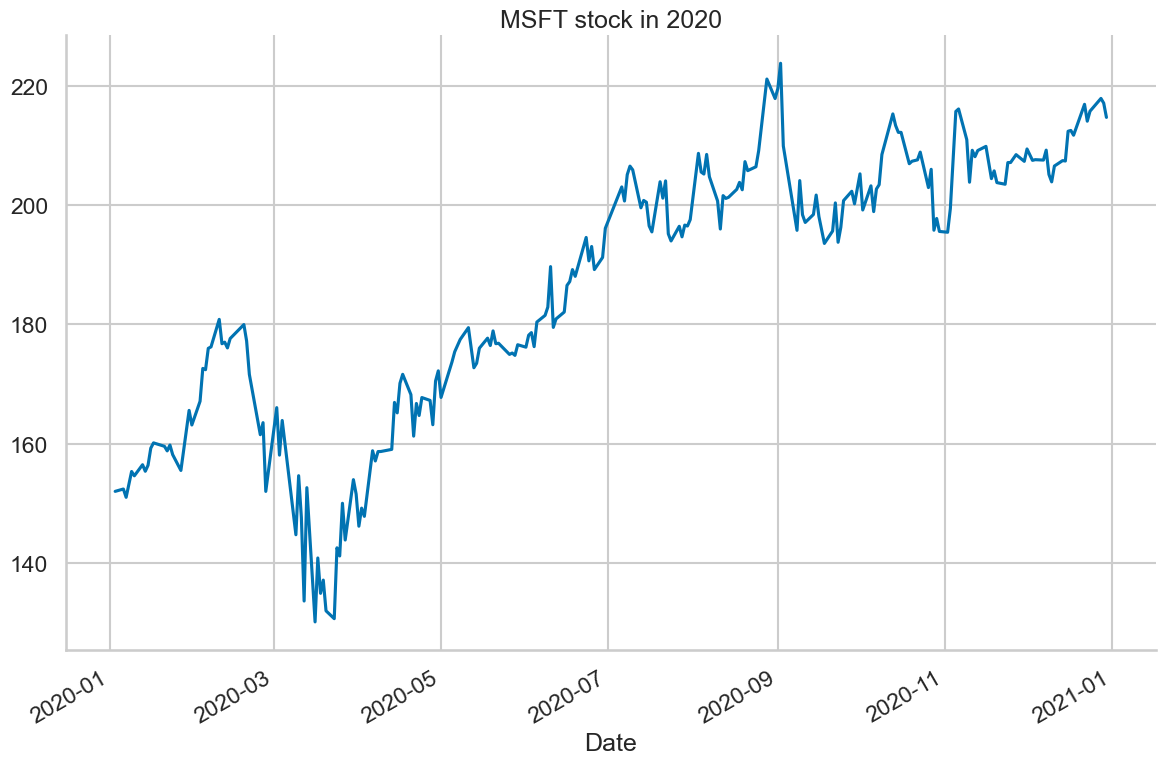

In [74]:
df = yf.download("MSFT",
                 start="2020-01-01", 
                 end="2020-12-31",
                 auto_adjust = False, 
                 progress=False)

df["simple_rtn"] = df["Adj Close"].pct_change()
df = df.dropna()

# 조정종가를 차트로 그리기
df["Adj Close"].plot(title="MSFT stock in 2020");

sns.despine()
plt.tight_layout()
# plt.savefig('images/figure_3_1', dpi=200)

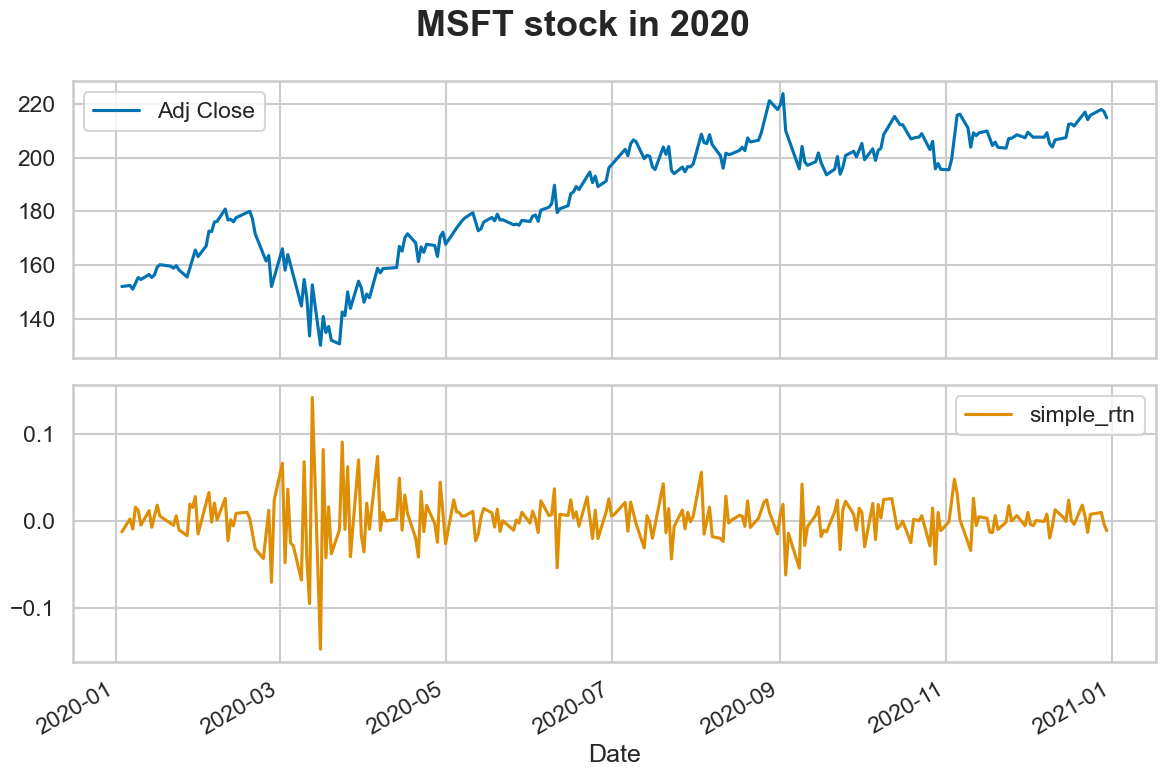

In [83]:
# 조정 종가와 단순 수익률을 하나의 그래프에 플롯
(    df[["Adj Close", "simple_rtn"]]
    .plot(subplots=True, sharex=True, 
          title="MSFT stock in 2020")
);
plt.tight_layout()
# plt.savefig('images/figure_3_2', dpi=200)

### multi-plotting
> 가격과 변동률을 함께 그려봅시다

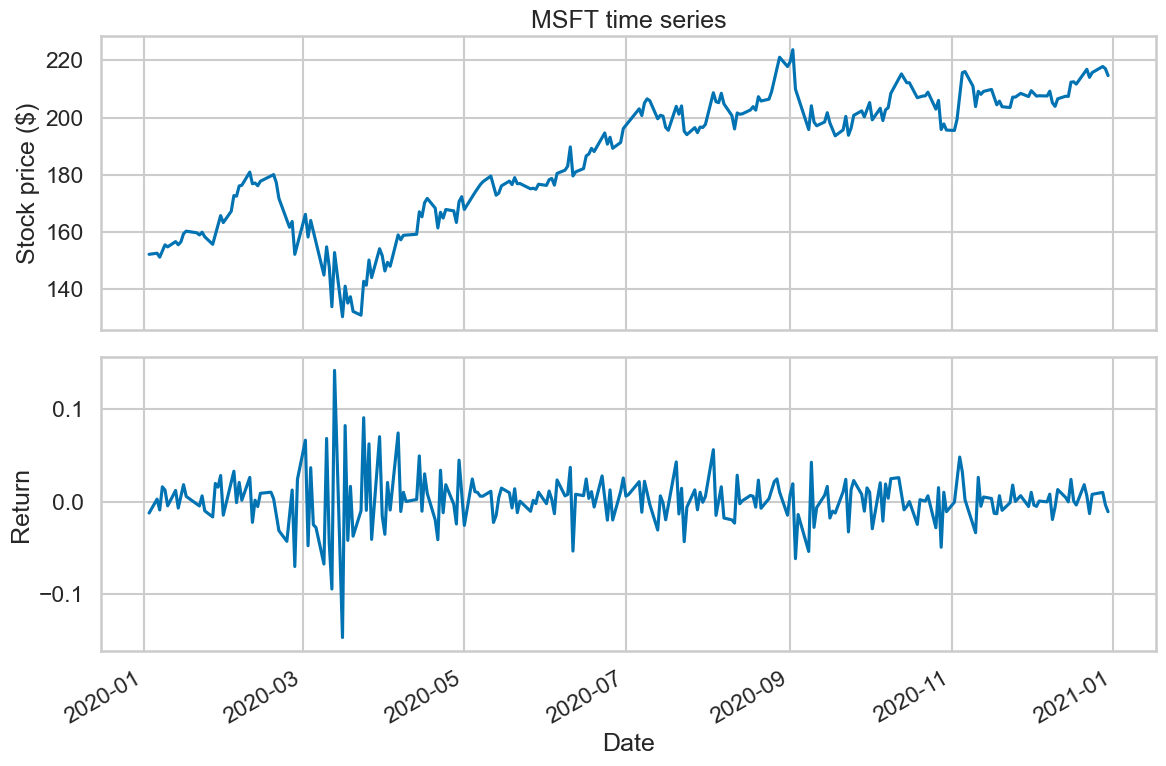

In [84]:
fig, ax = plt.subplots(2, 1, sharex=True)

# 가격
df["Adj Close"].plot(ax=ax[0])
ax[0].set(title="MSFT time series",
          ylabel="Stock price ($)")
    
#  변동률 
df["simple_rtn"].plot(ax=ax[1])
ax[1].set(ylabel="Return")

plt.tight_layout()
# plt.savefig('images/figure_3_3', dpi=200)

> `pandas`의 플로팅 백엔드를 `plotly`로 변경하기:

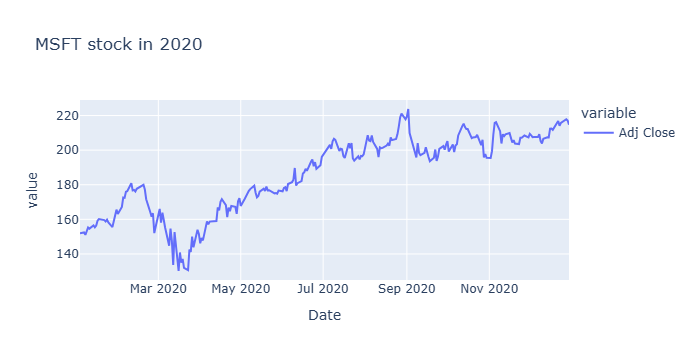

In [85]:
df["Adj Close"].plot(title="MSFT stock in 2020", backend="plotly")

## 3.2 계절 패턴 시각화

### 어떻게 하는지...

1. 라이브러리를 가져오고 인증하기:

In [92]:
import pandas as pd
import nasdaqdatalink
import seaborn as sns 
import os
from dotenv import load_dotenv
import fredpy as fp
fp.api_key = 'YOUR_API_KEY'
load_dotenv()

nasdaqdatalink.ApiConfig.api_key = os.getenv("nasdaq_link")
fp.api_key = os.getenv("fred_link")

2. Nasdaq 데이터 링크에서 실업 데이터 다운로드 및 표시:

In [183]:
df = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA", 
                       start_date="2016-01-01", 
                       end_date="2024-08-18")
    .rename(columns={"Value": "unemp_rate"})
)

# df = fp.series('UNRATE',
#               '2024-08-18').data
# df = df["2022-01-01"<=df.date].reset_index(drop=True)
df

,unemp_rate
Date,
2016-01-01,5.3
2016-02-01,5.2
2016-03-01,5.1
2016-04-01,4.7
2016-05-01,4.5
...,...
2021-09-01,4.6
2021-10-01,4.3
2021-11-01,3.9


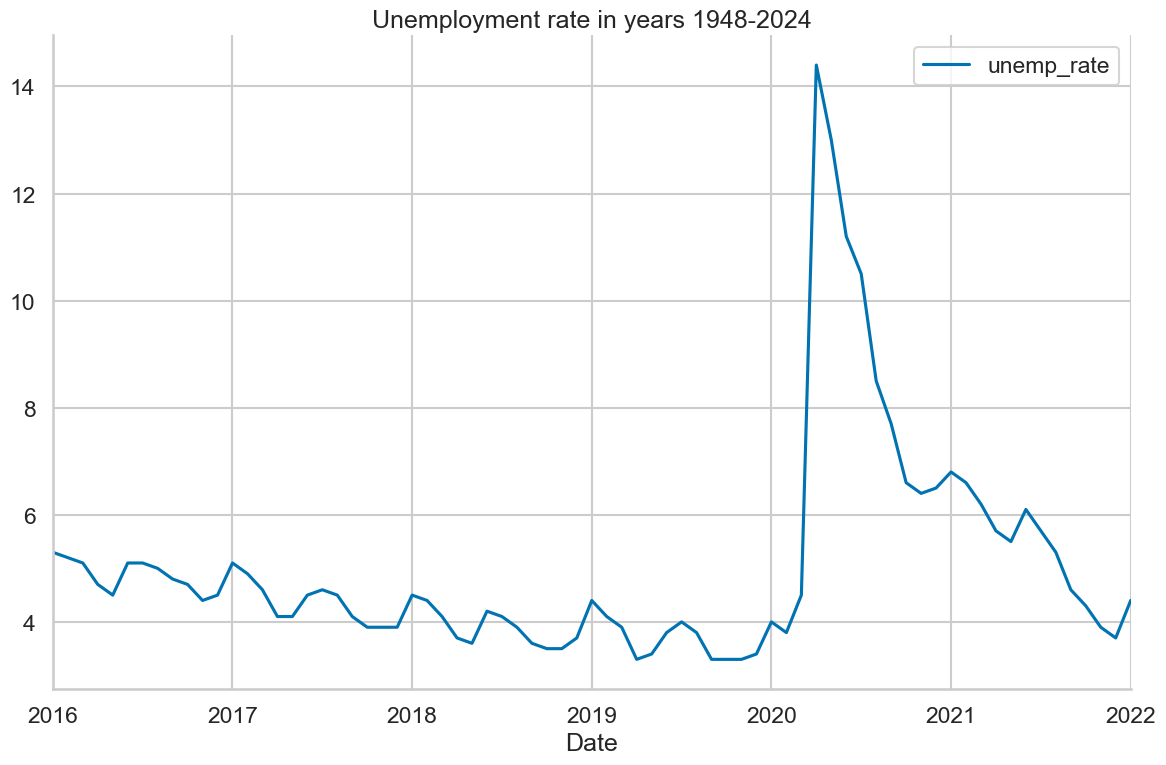

In [184]:
df.plot(title="Unemployment rate in years 1948-2024");
sns.despine()
plt.tight_layout()
# plt.savefig('images/figure_3_6', dpi=200)

3. 연도와 월로 새로운 열 만들기:

In [186]:
df["year"] = df.keys().year
df["month"] = df.keys().month


AttributeError: 'Index' object has no attribute 'year'

4. 계절별 플롯 만들기:

In [187]:
sns.lineplot(data=df, 
             x="month", 
             y="unemp_rate", 
             hue="year",
             style="year", 
             legend="full",
             palette="colorblind")

plt.title("Unemployment rate - Seasonal plot")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

sns.despine()
plt.tight_layout()
# plt.savefig('images/figure_3_7', dpi=200)

ValueError: Could not interpret value `month` for parameter `x`

### 더 알아보기

1. 라이브러리 가져오기:

In [188]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
import plotly.express as px

2. 월별 플롯 만들기:

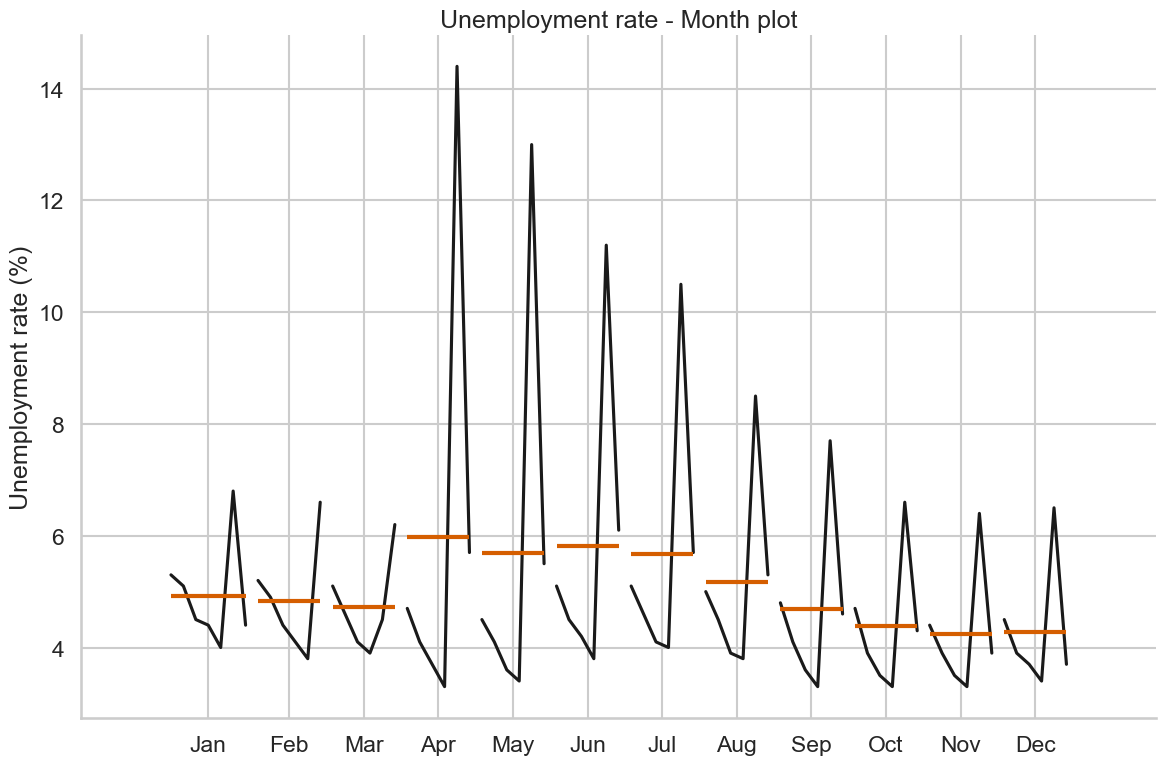

In [189]:
month_plot(df["unemp_rate"], ylabel="Unemployment rate (%)")
plt.title("Unemployment rate - Month plot");

sns.despine()
plt.tight_layout()
# plt.savefig('images/figure_3_8', dpi=200)

3. 분기 플롯 만들기:

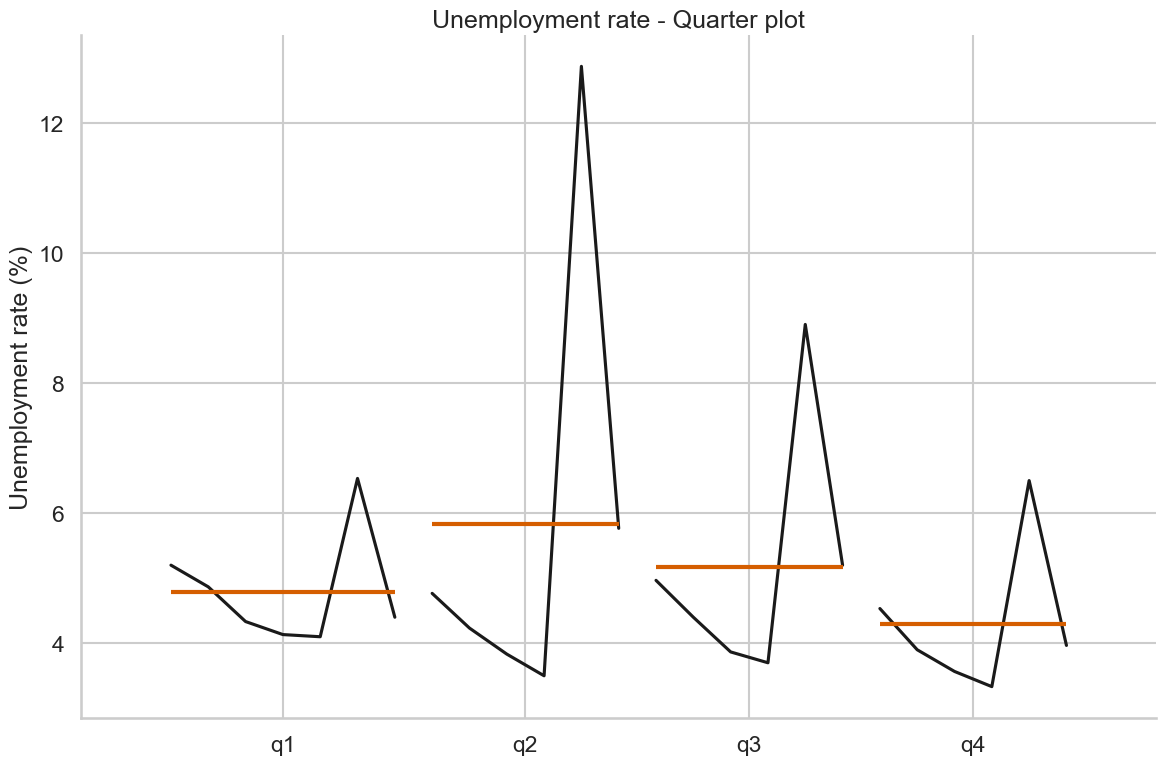

In [190]:
quarter_plot(df["unemp_rate"].resample("Q").mean(), 
             ylabel="Unemployment rate (%)")
plt.title("Unemployment rate - Quarter plot");

sns.despine()
plt.tight_layout()
# plt.savefig('images/figure_3_9', dpi=200)

4. `plotly.express`를 사용하여 극 계절 플롯을 생성합니다:

In [191]:
fig = px.line_polar(
    df, r="unemp_rate", theta="month", 
    color="year", line_close=True, 
    title="Unemployment rate - Polar seasonal plot",
    width=600, height=500,
    range_r=[3, 7]
)

fig.show()

ValueError: Value of 'theta' is not the name of a column in 'data_frame'. Expected one of ['unemp_rate'] but received: month

## 3.3 인터랙티브 시각화 만들기

1. 라이브러리를 가져오고 노트북 디스플레이를 초기화합니다:

In [192]:
# !pip install pandas-bokeh cufflinks

In [193]:
import pandas as pd 
import yfinance as yf

import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import pandas_bokeh

cf.go_offline()
# initialize notebook display
pandas_bokeh.output_notebook()

Loading BokehJS ...

2. 2020년의 마이크로소프트 주가를 다운로드하고 단순 수익률을 계산하세요.

In [194]:
df = yf.download("MSFT",
                 start="2020-01-01", 
                 end="2020-12-31",
                 auto_adjust = False, 
                 progress=False)

df["simple_rtn"] = df["Adj Close"].pct_change()
df = df.loc[:, ["Adj Close", "simple_rtn"]].dropna()
df = df.dropna()

3. `cufflinks`를 사용하여 플롯을 생성합니다:

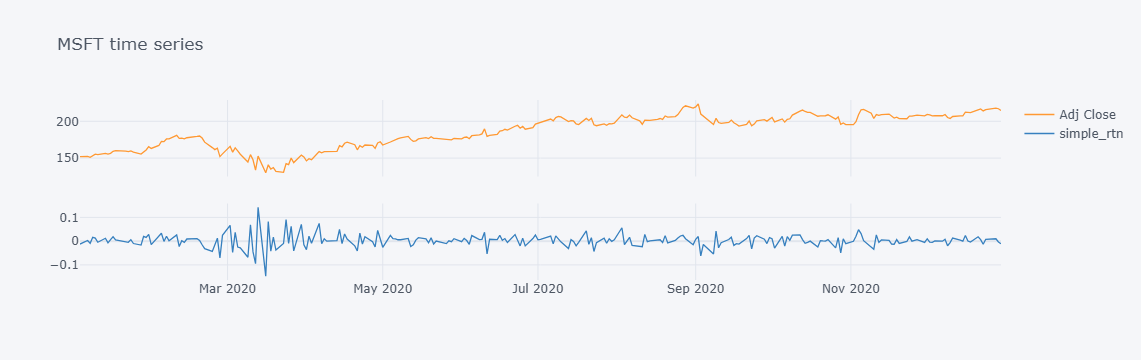

In [195]:
df.iplot(subplots=True, shape=(2,1), 
         shared_xaxes=True, 
         title="MSFT time series")

4. `bokeh`를 사용하여 플롯을 생성합니다:

In [196]:
from bokeh.plotting import figure

# Create a figure
p = figure(width=400, height=300)

# Add a line to the figure
p.line([1, 2, 3], [4, 5, 6])

# Display the figure
p.show()

AttributeError: unexpected attribute 'show' to figure, possible attributes are above, align, aspect_ratio, aspect_scale, attribution, background_fill_alpha, background_fill_color, below, border_fill_alpha, border_fill_color, center, context_menu, css_classes, css_variables, disabled, elements, extra_x_ranges, extra_x_scales, extra_y_ranges, extra_y_scales, flow_mode, frame_align, frame_height, frame_width, height, height_policy, hidpi, hold_render, inner_height, inner_width, js_event_callbacks, js_property_callbacks, left, lod_factor, lod_interval, lod_threshold, lod_timeout, margin, match_aspect, max_height, max_width, min_border, min_border_bottom, min_border_left, min_border_right, min_border_top, min_height, min_width, name, outer_height, outer_width, outline_line_alpha, outline_line_cap, outline_line_color, outline_line_dash, outline_line_dash_offset, outline_line_join, outline_line_width, output_backend, renderers, reset_policy, resizable, right, sizing_mode, styles, stylesheets, subscribed_events, syncable, tags, title, title_location, toolbar, toolbar_inner, toolbar_location, toolbar_sticky, visible, width, width_policy, x_range, x_scale, y_range or y_scale

In [197]:
df

,Adj Close,simple_rtn
Date,,
2020-01-03,152.021362,-0.012452
2020-01-06,152.414352,0.002585
2020-01-07,151.024658,-0.009118
2020-01-08,153.430283,0.015929
2020-01-09,155.347076,0.012493
...,...,...
2020-12-23,214.069565,-0.013039
2020-12-24,215.745148,0.007827
2020-12-28,217.885666,0.009922


In [198]:
df["Adj Close"].plot_bokeh(kind="line", 
                           rangetool=True, 
                           title="MSFT time series");

AttributeError: unexpected attribute 'plot_width' to figure, similar attributes are outer_width, width or min_width

5. `plotly.express`를 사용하여 플롯을 생성합니다:

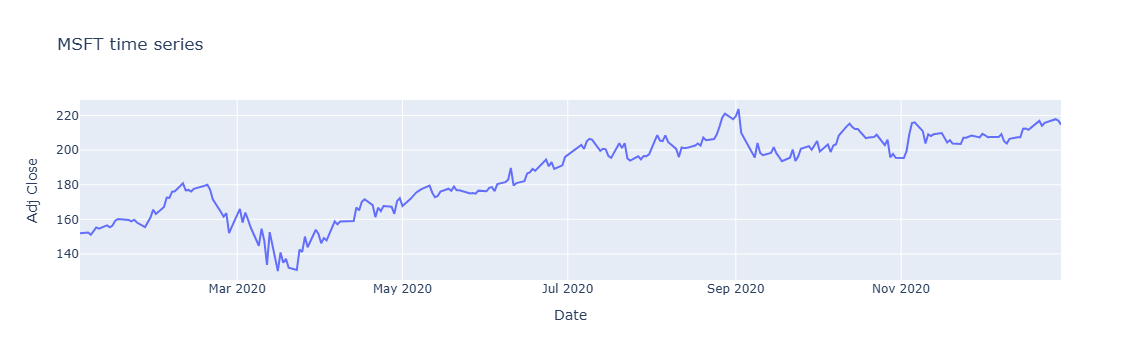

In [199]:
fig = px.line(data_frame=df, 
              y="Adj Close", 
              title="MSFT time series")
fig.show()

### 더 알아보기

1. 라이브러리 가져오기:

In [200]:
from datetime import date

2. `plotly` 플롯에 대한 주석을 정의합니다:

In [201]:
selected_date_1 = date(2020, 2, 19)
selected_date_2 = date(2020, 3, 23)

selected_y_1 = (
    df
    .query(f"index == '{selected_date_1}'")
    .loc[:, "Adj Close"]
    .squeeze()
)
selected_y_2 = (
    df
    .query(f"index == '{selected_date_2}'")
    .loc[:, "Adj Close"]
    .squeeze()
)

first_annotation = {
    "x": selected_date_1,
    "y": selected_y_1,
    "arrowhead": 5,
    "text": "COVID decline starting",
    "font": {"size": 15, "color": "red"},
}

second_annotation = {
    "x": selected_date_2,
    "y": selected_y_2,
    "arrowhead": 5,
    "text": "COVID recovery starting",
    "font": {"size": 15, "color": "green"},
    "ax": 150,
    "ay": 10
}

3. 플롯의 레이아웃을 업데이트하고 표시합니다:

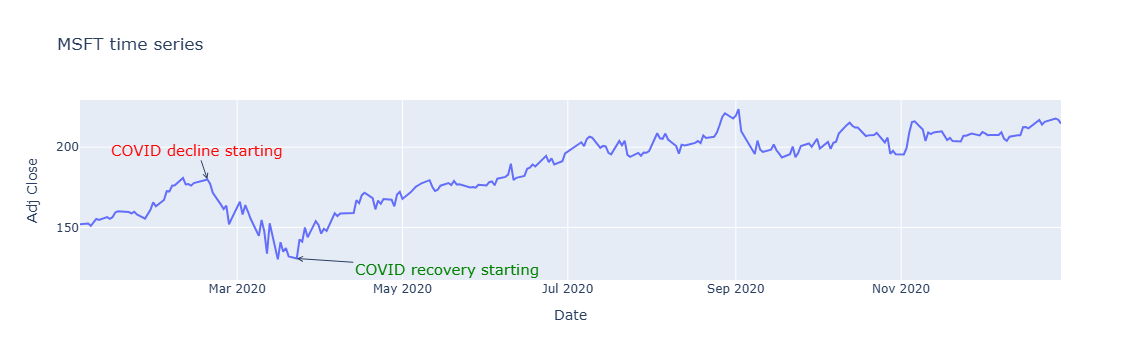

In [202]:
fig.update_layout(
    {"annotations": [first_annotation, second_annotation]}
)
fig.show()

## 3.4 캔들스틱 차트 만들기

### 준비하기

1. 라이브러리 가져오기:

In [203]:
import pandas as pd 
import yfinance as yf

2. 야후 파이낸스에서 조정된 가격을 다운로드하세요:

In [204]:
df = yf.download("X", 
                 start="2018-01-01", 
                 end="2018-12-31",
                 progress=False,
                 auto_adjust=True)

1. 라이브러리 가져오기:

In [205]:
import cufflinks as cf
from plotly.offline import iplot

cf.go_offline()

`cf.go_offline()`를 매번 실행하는 대신, `cf.set_config_file(offline=True)`를 실행하여 항상 오프라인 모드를 사용하도록 설정을 수정할 수 있습니다. 그런 다음 `cf.get_config_file()`를 사용하여 설정을 확인할 수 있습니다.

In [206]:
cf.set_config_file(offline=False)

In [207]:
cf.get_config_file()

{'sharing': 'public',
 'theme': 'pearl',
 'colorscale': 'dflt',
 'offline': False,
 'offline_connected': True,
 'offline_url': '',
 'offline_show_link': True,
 'offline_link_text': 'Export to plot.ly',
 'datagen_mode': 'stocks',
 'dimensions': None,
 'margin': None,
 'offline_config': None}

2. 트위터의 주가를 사용하여 캔들스틱 차트를 생성하세요.

In [208]:
qf = cf.QuantFig(
    df, title="Twitter's Stock Price", 
    legend="top", name="Twitter's stock prices in 2018"
)

3. 도표에 거래량과 이동 평균을 추가하세요:

In [209]:
qf.add_volume()
qf.add_sma(periods=20, column="Close", color="red")
qf.add_ema(periods=20, color="green") 

4. 플롯을 표시합니다:

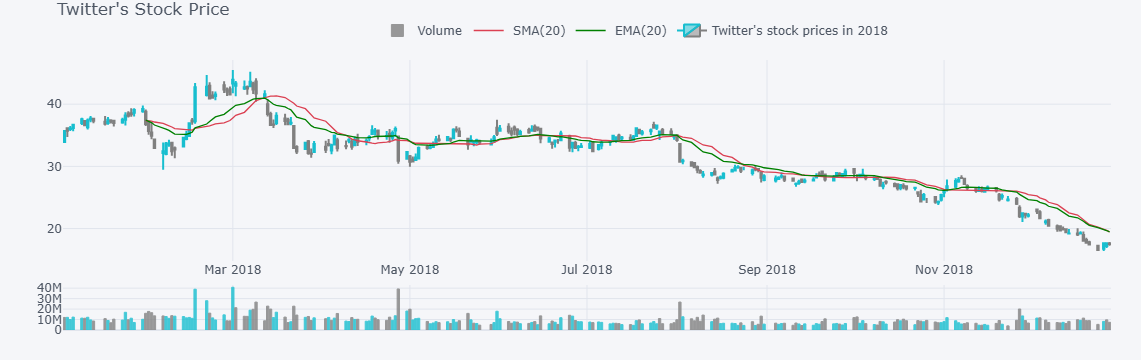

In [210]:
qf.iplot()

### 더 있습니다

1. 라이브러리 가져오기:

In [211]:
# !pip install mplfinance
import plotly.graph_objects as go
import mplfinance as mpf

2. `plotly`를 사용하여 캔들스틱 차트를 생성합니다:

In [212]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,33.913940,35.715945,33.742320,35.677807,11994700
2018-01-03,36.116383,36.259397,34.705289,35.744541,12109800
2018-01-04,35.992438,36.497761,35.687336,36.106850,9990200
2018-01-05,36.154521,36.736122,35.649198,36.697987,12323900
2018-01-08,36.955418,37.823051,36.640784,37.584690,11371000
...,...,...,...,...,...
2018-12-21,17.805403,18.016460,17.373700,17.450447,8947300
2018-12-24,17.220205,17.325732,16.548665,16.567852,5377800
2018-12-26,16.740534,17.671096,16.395170,17.651909,8232000


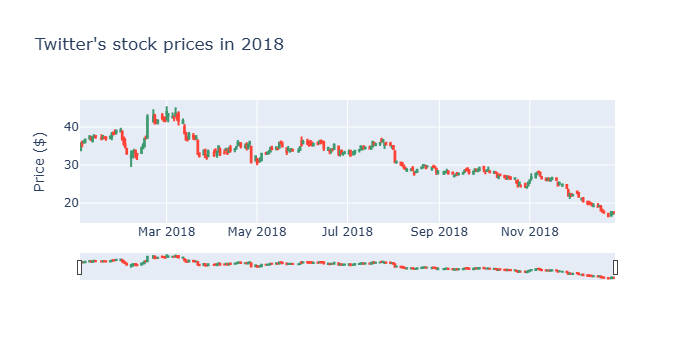

In [55]:
fig = go.Figure(data=
    go.Candlestick(x=df.index,
                   open=df["Open"],
                   high=df["High"],
                   low=df["Low"],
                   close=df["Close"])
)

fig.update_layout(
    title="Twitter's stock prices in 2018",
    yaxis_title="Price ($)"
)

fig.show()

3. `mplfinance`를 사용하여 캔들스틱 차트를 생성합니다:

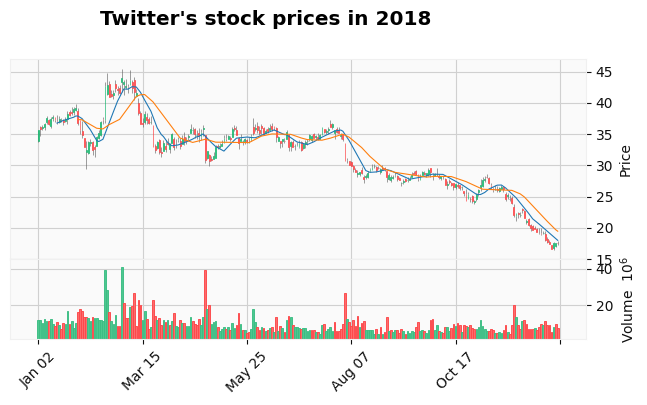

<Figure size 640x480 with 0 Axes>

In [56]:
mpf.plot(df, type="candle", 
         mav=(10, 20), 
         volume=True, 
         style="yahoo", 
         title="Twitter's stock prices in 2018", 
         figsize=(8, 4));

sns.despine()
plt.tight_layout()